### Mustafa Kutay Yabas - EC581 - 08.10.2016
# Assignment #2.2

## Hypothesis
Indexes S&P 500 and NASDAQ 100 moves in correlation.
Correlation breaks can be traded for statistical arbitrage.

## Indicators
    - SPX Index
    - NAS Index

## Signals
    1. Difference of log returns of SPX and NAS
    2. Filtered Difference of 1

In [13]:
library(TTR)
library(zoo)
library(Quandl)
library(quantmod)
library(blotter)

In [2]:
# NASDAQ 100 Index
nas = Quandl("NASDAQOMX/XQO", start_date="2015-01-01")

# S&P 500 Index
spx = Quandl("YAHOO/INDEX_GSPC", start_date="2015-01-01")

# Data is scarse so started from 2015-01-01

In [3]:
# convert to zoo objects
znas = zoo(nas[,2], order.by=nas[,1])
zspx = zoo(spx[,5], order.by=spx[,1])

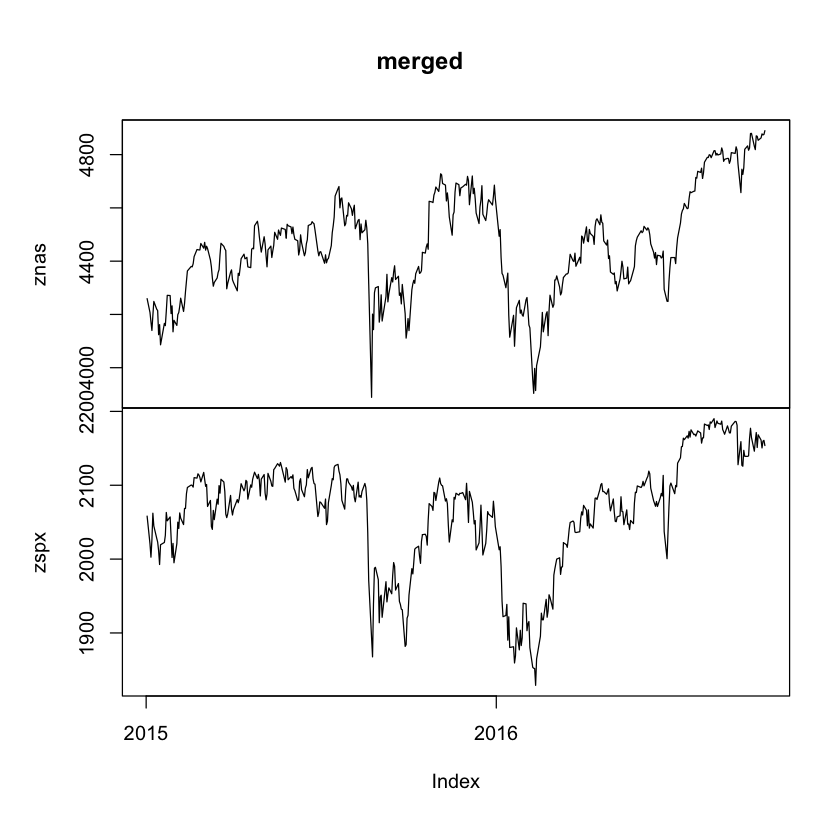

In [4]:
merged = merge(znas, zspx)
plot(merged)

### There is a high correlation between SPX and NAS

In [5]:
cor(na.locf(merged$znas),na.locf(merged$zspx))

[1] 0.8051297

### But it is not exactly 1. So a statistical arbitrage opportunity may be found

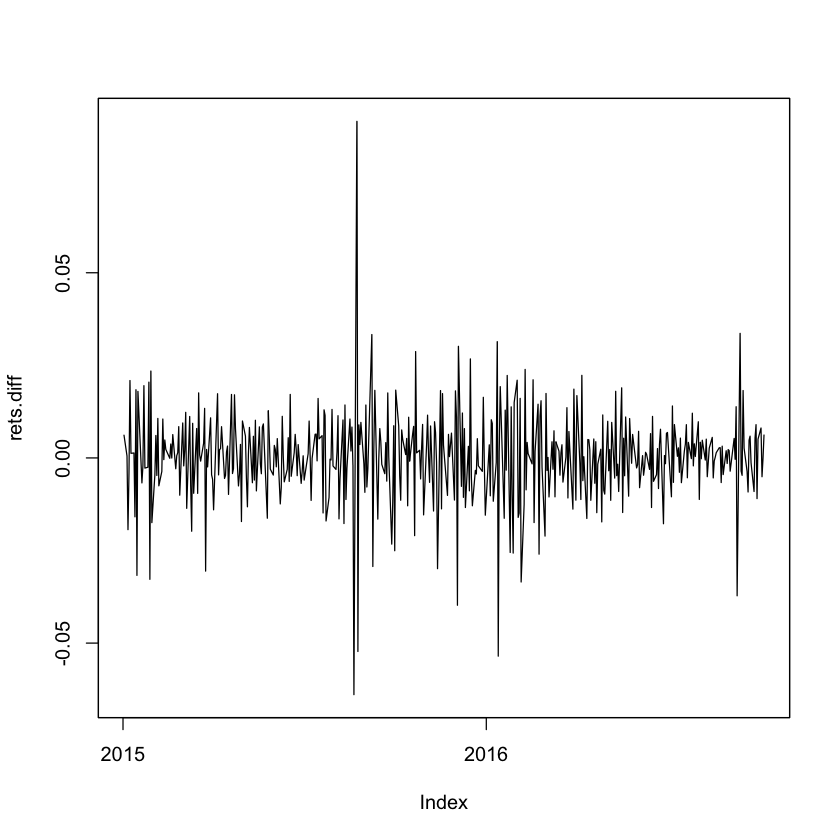

In [6]:
# find the returns

znas.rets = log(lag(znas)) - log(znas)
zspx.rets = log(lag(zspx)) - log(zspx)

rets.diff = znas.rets - zspx.rets
plot(rets.diff)

### Filter out the differences more than 0.02

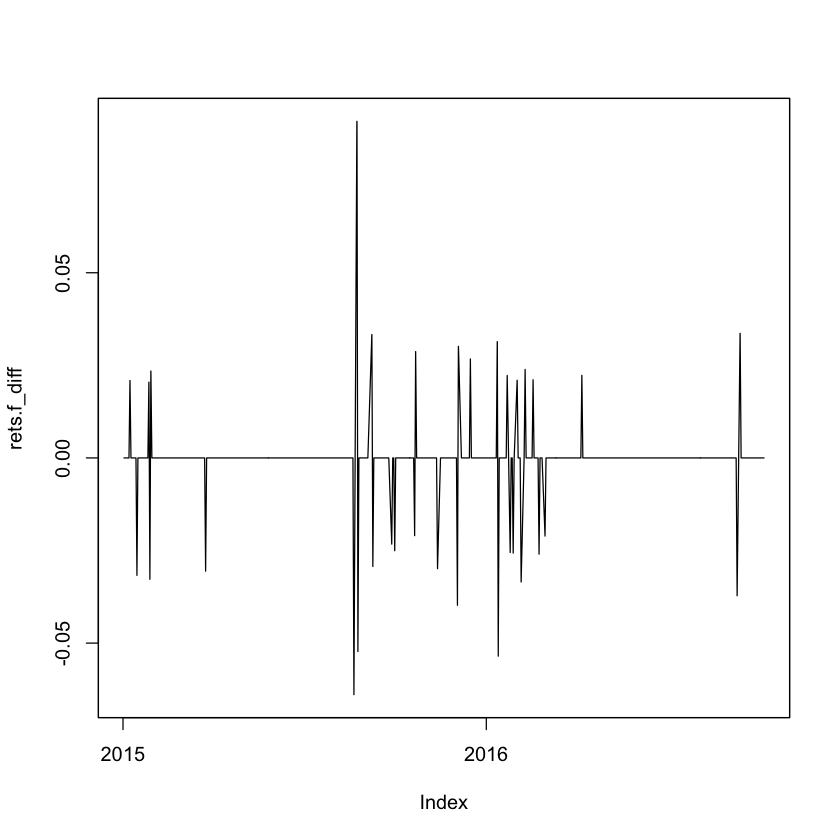

In [7]:
rets.f_diff = rets.diff*0 #filtered rets diff
#na.fill(rets.diff, fill=0)

for (i in 1:length(rets.diff)) {
    #print(abs(as.numeric(rets.diff[i])))
    if (abs(as.numeric(rets.diff[i])) > 0.02) {
        rets.f_diff[i] = rets.diff[i]
    }
}

plot(rets.f_diff)

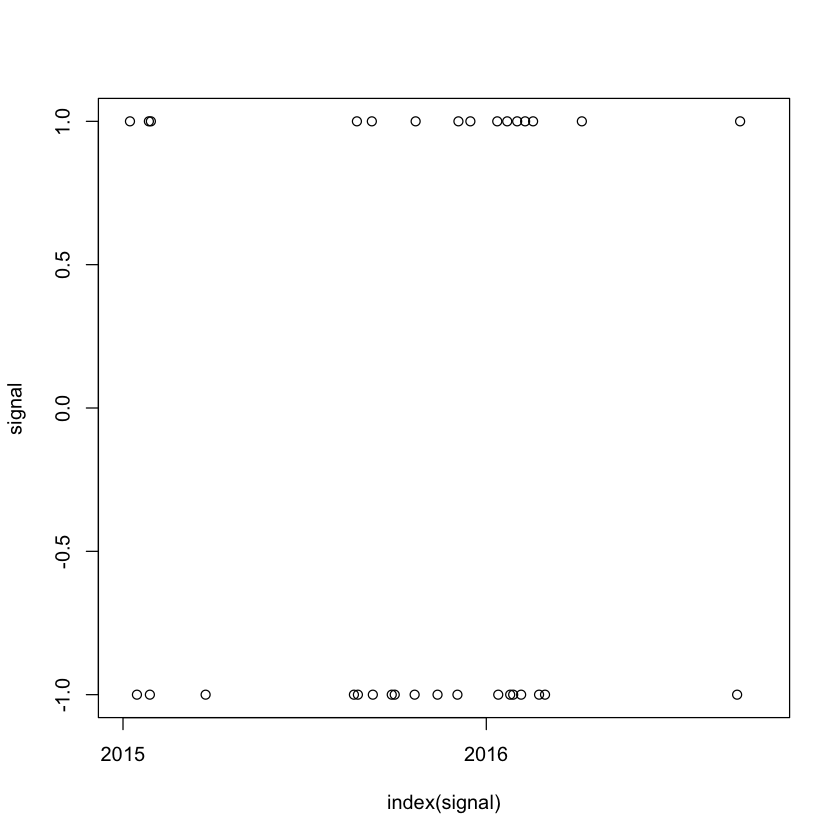

In [8]:
signal = sign(rets.f_diff)
signal[signal == 0] = NA
plot(index(signal),signal)

## When Signal == 1 Sell Spx, Buy Nas
## When Signal == -1 Buy Spx, Sell Nas

In [9]:
## test the strategy with blotter
library(blotter)

currency("USD")
stock("NAS", currency="USD", multiplier=1)
stock("SPX", currency="USD", multiplier=1)
Sys.setenv(TZ="UTC")

NAS<-xts(znas[,1] , order.by=index(znas[,1]))
SPX<-xts(zspx[,1] , order.by=index(zspx[,1]))

my.strategy <- "Arbitrage"
initPortf(my.strategy, symbols=list('NAS','SPX'), initDate="2015-01-01")
initAcct(my.strategy, portfolios=my.strategy, initDate="2015-01-01", initEq=1000000)

[1] "USD"

[1] "NAS"

[1] "SPX"

[1] "Arbitrage"

[1] "Arbitrage"

In [10]:
NAS<-xts(znas[,1] , order.by=index(znas[,1]))
SPX<-xts(zspx[,1] , order.by=index(zspx[,1]))
colnames(NAS) <- 'Price'
colnames(SPX) <- 'Price'

#NAS<-xts(NAS[,1], as.POSIXct(time(NAS))) ?
#SPX<-xts(SPX[,1], as.POSIXct(time(SPX))) ?

for (i in 1:length(signal)) {
    if(!is.na(signal[i])) {
        current_date = index(signal[i])
        qty = 100
        nas_price = as.numeric(znas[index(signal[i])])
        spx_price = as.numeric(zspx[index(signal[i])])
        if (as.numeric(signal[i]) == 1) {
            # Sell nas, buy spx
            addTxn(my.strategy, Symbol="NAS", TxnDate=current_date, TxnPrice=nas_price, TxnQty = qty, TxnFees=0)
            addTxn(my.strategy, Symbol="SPX", TxnDate=current_date, TxnPrice=spx_price, TxnQty = -qty, TxnFees=0)
        } else if (as.numeric(signal[i]) == -1) {
            #sell nass, buy spx
            addTxn(my.strategy, Symbol="NAS", TxnDate=current_date, TxnPrice=nas_price, TxnQty = -qty, TxnFees=0)
            addTxn(my.strategy, Symbol="SPX", TxnDate=current_date, TxnPrice=spx_price, TxnQty = qty, TxnFees=0)
        }
        
        updatePortf(my.strategy, Dates=current_date)
        updateAcct(my.strategy, Dates=current_date)
        updateEndEq(my.strategy, current_date)

    }
}

[1] "2015-01-08 00:00:00 NAS 100 @ 4196.26"
[1] "2015-01-08 00:00:00 SPX -100 @ 2062.139893"


Warning message in updatePortf(my.strategy, Dates = current_date):
“Incompatible methods ("Ops.POSIXt", "Ops.Date") for ">="”

[1] "2015-01-15 00:00:00 NAS -100 @ 4161.69"
[1] "2015-01-15 00:00:00 SPX 100 @ 1992.670044"


Warning message in updatePortf(my.strategy, Dates = current_date):
“Incompatible methods ("Ops.POSIXt", "Ops.Date") for ">="”

[1] "2015-01-27 00:00:00 NAS 100 @ 4203.18"
[1] "2015-01-27 00:00:00 SPX -100 @ 2029.550049"


Warning message in updatePortf(my.strategy, Dates = current_date):
“Incompatible methods ("Ops.POSIXt", "Ops.Date") for ">="”

[1] "2015-01-28 00:00:00 NAS -100 @ 4232.19"
[1] "2015-01-28 00:00:00 SPX 100 @ 2002.160034"


Warning message in updatePortf(my.strategy, Dates = current_date):
“Incompatible methods ("Ops.POSIXt", "Ops.Date") for ">="”

[1] "2015-01-29 00:00:00 NAS 100 @ 4134.77"
[1] "2015-01-29 00:00:00 SPX -100 @ 2021.25"


Warning message in updatePortf(my.strategy, Dates = current_date):
“Incompatible methods ("Ops.POSIXt", "Ops.Date") for ">="”

[1] "2015-03-25 00:00:00 NAS -100 @ 4440.14"
[1] "2015-03-25 00:00:00 SPX 100 @ 2061.050049"


Warning message in updatePortf(my.strategy, Dates = current_date):
“Incompatible methods ("Ops.POSIXt", "Ops.Date") for ">="”

[1] "2015-08-21 00:00:00 NAS -100 @ 4315.56"
[1] "2015-08-21 00:00:00 SPX 100 @ 1970.890015"


Warning message in updatePortf(my.strategy, Dates = current_date):
“Incompatible methods ("Ops.POSIXt", "Ops.Date") for ">="”

[1] "2015-08-24 00:00:00 NAS 100 @ 3888.77"
[1] "2015-08-24 00:00:00 SPX -100 @ 1893.209961"


Warning message in updatePortf(my.strategy, Dates = current_date):
“Incompatible methods ("Ops.POSIXt", "Ops.Date") for ">="”

[1] "2015-08-25 00:00:00 NAS -100 @ 4201.18"
[1] "2015-08-25 00:00:00 SPX 100 @ 1867.609985"


Warning message in updatePortf(my.strategy, Dates = current_date):
“Incompatible methods ("Ops.POSIXt", "Ops.Date") for ">="”

[1] "2015-09-08 00:00:00 NAS 100 @ 4267.29"
[1] "2015-09-08 00:00:00 SPX -100 @ 1969.410034"


Warning message in updatePortf(my.strategy, Dates = current_date):
“Incompatible methods ("Ops.POSIXt", "Ops.Date") for ">="”

[1] "2015-09-09 00:00:00 NAS -100 @ 4350.55"
[1] "2015-09-09 00:00:00 SPX 100 @ 1942.040039"


Warning message in updatePortf(my.strategy, Dates = current_date):
“Incompatible methods ("Ops.POSIXt", "Ops.Date") for ">="”

[1] "2015-09-28 00:00:00 NAS -100 @ 4202.69"
[1] "2015-09-28 00:00:00 SPX 100 @ 1881.77002"


Warning message in updatePortf(my.strategy, Dates = current_date):
“Incompatible methods ("Ops.POSIXt", "Ops.Date") for ">="”

[1] "2015-10-01 00:00:00 NAS -100 @ 4184.48"
[1] "2015-10-01 00:00:00 SPX 100 @ 1923.819946"


Warning message in updatePortf(my.strategy, Dates = current_date):
“Incompatible methods ("Ops.POSIXt", "Ops.Date") for ">="”

[1] "2015-10-21 00:00:00 NAS -100 @ 4464.82"
[1] "2015-10-21 00:00:00 SPX 100 @ 2018.939941"


Warning message in updatePortf(my.strategy, Dates = current_date):
“Incompatible methods ("Ops.POSIXt", "Ops.Date") for ">="”

[1] "2015-10-22 00:00:00 NAS 100 @ 4444.79"
[1] "2015-10-22 00:00:00 SPX -100 @ 2052.51001"


Warning message in updatePortf(my.strategy, Dates = current_date):
“Incompatible methods ("Ops.POSIXt", "Ops.Date") for ">="”

[1] "2015-11-13 00:00:00 NAS -100 @ 4566"
[1] "2015-11-13 00:00:00 SPX 100 @ 2023.040039"


Warning message in updatePortf(my.strategy, Dates = current_date):
“Incompatible methods ("Ops.POSIXt", "Ops.Date") for ">="”

[1] "2015-12-03 00:00:00 NAS -100 @ 4702.52"
[1] "2015-12-03 00:00:00 SPX 100 @ 2049.620117"


Warning message in updatePortf(my.strategy, Dates = current_date):
“Incompatible methods ("Ops.POSIXt", "Ops.Date") for ">="”

[1] "2015-12-04 00:00:00 NAS 100 @ 4611.89"
[1] "2015-12-04 00:00:00 SPX -100 @ 2091.689941"


Warning message in updatePortf(my.strategy, Dates = current_date):
“Incompatible methods ("Ops.POSIXt", "Ops.Date") for ">="”

[1] "2015-12-16 00:00:00 NAS 100 @ 4629.35"
[1] "2015-12-16 00:00:00 SPX -100 @ 2073.070068"


Warning message in updatePortf(my.strategy, Dates = current_date):
“Incompatible methods ("Ops.POSIXt", "Ops.Date") for ">="”

[1] "2016-01-12 00:00:00 NAS 100 @ 4328.53"
[1] "2016-01-12 00:00:00 SPX -100 @ 1938.680054"


Warning message in updatePortf(my.strategy, Dates = current_date):
“Incompatible methods ("Ops.POSIXt", "Ops.Date") for ">="”

[1] "2016-01-13 00:00:00 NAS -100 @ 4355.09"
[1] "2016-01-13 00:00:00 SPX 100 @ 1890.280029"


Warning message in updatePortf(my.strategy, Dates = current_date):
“Incompatible methods ("Ops.POSIXt", "Ops.Date") for ">="”

[1] "2016-01-22 00:00:00 NAS 100 @ 4225.39"
[1] "2016-01-22 00:00:00 SPX -100 @ 1906.900024"


Warning message in updatePortf(my.strategy, Dates = current_date):
“Incompatible methods ("Ops.POSIXt", "Ops.Date") for ">="”

[1] "2016-01-25 00:00:00 NAS -100 @ 4252.99"
[1] "2016-01-25 00:00:00 SPX 100 @ 1877.079956"


Warning message in updatePortf(my.strategy, Dates = current_date):
“Incompatible methods ("Ops.POSIXt", "Ops.Date") for ">="”

[1] "2016-01-28 00:00:00 NAS -100 @ 4198.53"
[1] "2016-01-28 00:00:00 SPX 100 @ 1893.359985"


Warning message in updatePortf(my.strategy, Dates = current_date):
“Incompatible methods ("Ops.POSIXt", "Ops.Date") for ">="”

[1] "2016-02-01 00:00:00 NAS 100 @ 4254.74"
[1] "2016-02-01 00:00:00 SPX -100 @ 1939.380005"


Warning message in updatePortf(my.strategy, Dates = current_date):
“Incompatible methods ("Ops.POSIXt", "Ops.Date") for ">="”

[1] "2016-02-05 00:00:00 NAS -100 @ 4149.78"
[1] "2016-02-05 00:00:00 SPX 100 @ 1880.050049"


Warning message in updatePortf(my.strategy, Dates = current_date):
“Incompatible methods ("Ops.POSIXt", "Ops.Date") for ">="”

[1] "2016-02-09 00:00:00 NAS 100 @ 3903.71"
[1] "2016-02-09 00:00:00 SPX -100 @ 1852.209961"


Warning message in updatePortf(my.strategy, Dates = current_date):
“Incompatible methods ("Ops.POSIXt", "Ops.Date") for ">="”

[1] "2016-02-17 00:00:00 NAS 100 @ 4139.02"
[1] "2016-02-17 00:00:00 SPX -100 @ 1926.819946"


Warning message in updatePortf(my.strategy, Dates = current_date):
“Incompatible methods ("Ops.POSIXt", "Ops.Date") for ">="”

[1] "2016-02-23 00:00:00 NAS -100 @ 4210.1"
[1] "2016-02-23 00:00:00 SPX 100 @ 1921.27002"


Warning message in updatePortf(my.strategy, Dates = current_date):
“Incompatible methods ("Ops.POSIXt", "Ops.Date") for ">="”

[1] "2016-02-29 00:00:00 NAS -100 @ 4226.76"
[1] "2016-02-29 00:00:00 SPX 100 @ 1932.22998"


Warning message in updatePortf(my.strategy, Dates = current_date):
“Incompatible methods ("Ops.POSIXt", "Ops.Date") for ">="”

[1] "2016-04-06 00:00:00 NAS 100 @ 4473"
[1] "2016-04-06 00:00:00 SPX -100 @ 2066.659912"


Warning message in updatePortf(my.strategy, Dates = current_date):
“Incompatible methods ("Ops.POSIXt", "Ops.Date") for ">="”

[1] "2016-09-09 00:00:00 NAS -100 @ 4764.01"
[1] "2016-09-09 00:00:00 SPX 100 @ 2127.810059"


Warning message in updatePortf(my.strategy, Dates = current_date):
“Incompatible methods ("Ops.POSIXt", "Ops.Date") for ">="”

[1] "2016-09-12 00:00:00 NAS 100 @ 4657.29"
[1] "2016-09-12 00:00:00 SPX -100 @ 2159.040039"


Warning message in updatePortf(my.strategy, Dates = current_date):
“Incompatible methods ("Ops.POSIXt", "Ops.Date") for ">="”

In [11]:
PortfReturns(Account="Arbitrage")

           NAS.DailyEndEq SPX.DailyEndEq
2015-01-07       0.000000   0.0000000000
2015-01-08       0.000000   0.0000000000
2015-01-14       0.000000   0.0000000000
2015-01-15       0.003780   0.0018599976
2015-01-26       0.000000   0.0000000000
2015-01-27       0.000000   0.0000000000
2015-01-28       0.426120  -0.1974770019
2015-01-29       0.000000   0.0000000000
2015-03-24       0.000000   0.0000000000
2015-03-25      -0.000570   0.0030449951
2015-08-20       0.000000   0.0000000000
2015-08-21       0.000000   0.0000000000
2015-08-24      -0.346198   0.1815529907
2015-08-25       0.000000   0.0000000000
2015-09-08      -0.435939   0.2017600097
2015-09-09       0.000000   0.0000000000
2015-09-28       0.010987  -0.0049569946
2015-09-30       0.000000   0.0000000000
2015-10-01      -0.008876   0.0007579834
2015-10-20       0.000000   0.0000000000
2015-10-21      -1.343025   0.6021329586
2015-10-22       0.008012   0.0134280276
2015-11-12       0.000000   0.0000000000
2015-11-13      

In [12]:
getEndEq(my.strategy, '2016-09-12')

[1] 1144174